# Flower classification

Welcome to the Flower Image Classifier !

This web application allows you to easily classify flower images using state-of-the-art machine learning models. Simply upload an image of a flower, and our powerful classification model will analyze it and predict the type of flower it belongs to.

In [ ]:
# This line displays information about the available NVIDIA GPU(s) in the Colab environment
!nvidia-smi

Tue Jul 11 08:52:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This line installs the Gradio library using pip, which is a user interface library for creating web-based UIs for machine learning models
!pip install gradio

In [ ]:
# Import the Gradio library for creating the web application
import gradio as gr

# Import the necessary libraries for image handling, visualization, and deep learning
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# Import specific components from TensorFlow and Keras for building the model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
"""
pathlib : Import the pathlib library for working with directories and file paths
dataset_url : The URL where the flower dataset is located
Download the flower dataset and save it to the data_dir path
Convert the data_dir path into a pathlib.Path object for easier directory manipulation

"""


import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

/root/.keras/datasets/flower_photos/dandelion/458011386_ec89115a19.jpg


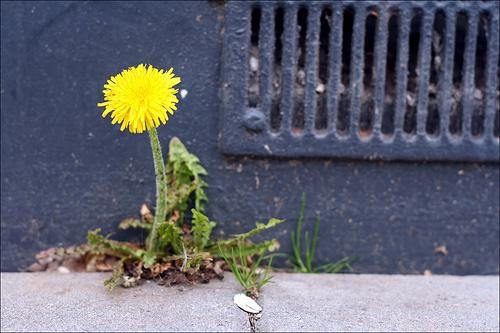

In [ ]:
"""
Get a list of file paths for all the images in the 'roses' subdirectory of the data directory
Print the first image file path in the 'roses' list
PIL:Open and display the image using PIL (Python Imaging Library)

"""

roses = list(data_dir.glob('dandelion/*'))
print(roses[0])
PIL.Image.open(str(roses[0]))

In [ ]:
"""
Set the desired image height and width and batch_size

# Create a TensorFlow image dataset from the directory
# - 'data_dir': The path to the directory containing the image dataset
# - 'validation_split': The fraction of the data to use for validation (in this case, 20%)
# - 'subset': Specifies whether to use a subset of the data for training or validation
# - 'seed': The random seed for shuffling and splitting the dataset
# - 'image_size': The target size for resizing the images in the dataset
# - 'batch_size': The number of samples per batch during training

"""


img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
"""
# Create a TensorFlow image dataset from the directory for validation
# - 'data_dir': The path to the directory containing the image dataset
# - 'validation_split': The fraction of the data to use for validation (in this case, 20%)
# - 'subset': Specifies whether to use a subset of the data for training or validation (in this case, validation)
# - 'seed': The random seed for shuffling and splitting the dataset
# - 'image_size': The target size for resizing the images in the dataset
# - 'batch_size': The number of samples per batch during validation
"""

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Get the class names from the training dataset and print them
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


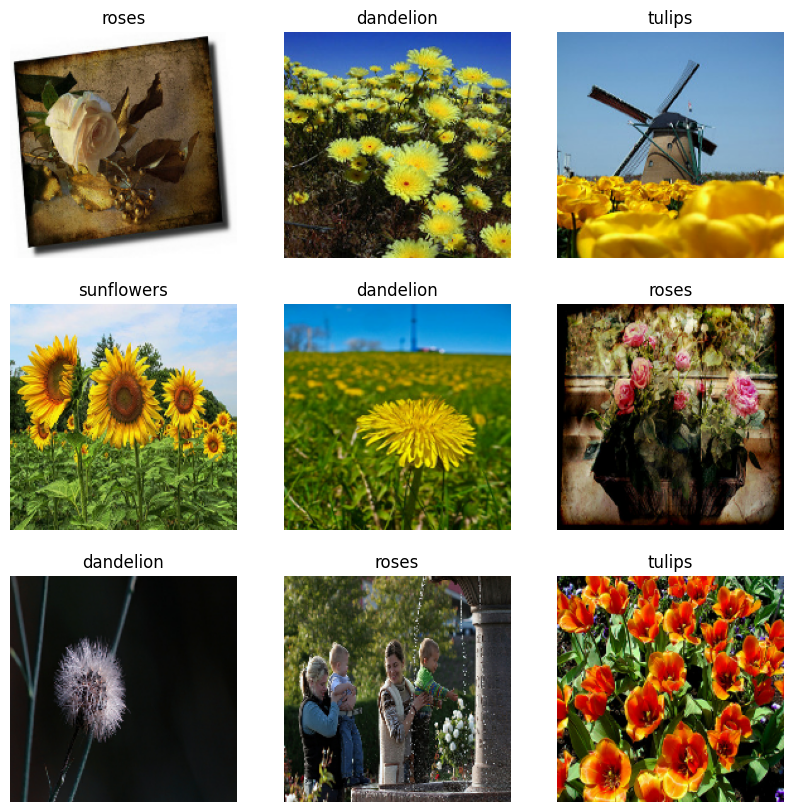

In [ ]:
"""
 - Create a new figure with a size of 10x10 inches
 - Iterate over the first batch of images and labels in the training dataset.
 - Then, Iterate over the images in the batch
 - Create a subplot with 3 rows, 3 columns, and an index (i+1)
 - Display the image by converting it to a numpy array of type "uint8"
 - Set the title of the subplot as the corresponding class name based on the label
 - Turn off the axis labels
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
"""
Model :
 - Create a sequential model
 - Preprocess the input by scaling the pixel values to the range [0, 1]
 - Convolutional layer with 16 filters, kernel size of 3x3, 'same' padding, and ReLU activation
 - Max pooling layer with default parameters (2x2 pool size and stride of 2)
 - Convolutional layer with 32 filters, kernel size of 3x3, 'same' padding, and ReLU activation
 - Max pooling layer with default parameters
 - Convolutional layer with 64 filters, kernel size of 3x3, 'same' padding, and ReLU activation
 - Max pooling layer with default parameters
 - Flatten the input to a 1D array
 - Fully connected layer with 128 units and ReLU activation
 - Output layer with num_classes units and softmax activation for multi-class classification

"""
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
"""
Compile the model with the Adam optimizer, SparseCategoricalCrossentropy loss function,
and accuracy as the evaluation metric
"""
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model on the training dataset, and validate it on the validation dataset
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 26s 117ms/step - loss: 1.3144 - accuracy: 0.4615 - val_loss: 1.1123 - val_accuracy: 0.5804
Epoch 2/10
92/92 [==============================] - 7s 76ms/step - loss: 1.0215 - accuracy: 0.6008 - val_loss: 1.0593 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 8s 71ms/step - loss: 0.8644 - accuracy: 0.6683 - val_loss: 0.9669 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 8s 82ms/step - loss: 0.6871 - accuracy: 0.7463 - val_loss: 0.9810 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 8s 83ms/step - loss: 0.4959 - accuracy: 0.8249 - val_loss: 1.0258 - val_accuracy: 0.6649
Epoch 6/10
92/92 [==============================] - 7s 67ms/step - loss: 0.3012 - accuracy: 0.8988 - val_loss: 1.3071 - val_accuracy: 0.6131
Epoch 7/10
92/92 [==============================] - 8s 80ms/step - loss: 0.1610 - accuracy: 0.9479 - val_loss: 1.6995 - val_accuracy: 0.6008
Epoch 8/10
92/92 [====

In [ ]:
"""
- Reshape the input image to a 4D array
- Make a prediction using the trained model
- Create a dictionary of class names and corresponding prediction probabilities
- Return the dictionary of predictions

"""

def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(5)}

In [ ]:
"""
 - Define the Gradio inputs and outputs
 - Create the Gradio interface with the defined function, inputs, and outputs
 - Launch the Gradio interface in debug mode
"""

# Input image with shape (180, 180)
image = gr.inputs.Image(shape=(180,180))
# Output label with top 5 classes
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

<ipython-input-20-07217a1c46fe>:8: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(180,180))
<ipython-input-20-07217a1c46fe>:8: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(180,180))
<ipython-input-20-07217a1c46fe>:10: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=5)
<ipython-input-20-07217a1c46fe>:10: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=5)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 39ms/step
